## Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

import warnings
warnings.filterwarnings("ignore")

## Paths

In [2]:
TRAIN = '../Data/df_train.csv'
TEST = '../Data/df_test.csv'

## Functions

In [3]:
# code from exercise 5 to calcuulate the z-score
z_score = lambda x : (x - np.mean(x, axis=0)) / np.std(x, axis=0)

## Variables and df loading

In [4]:
col = 'tab10' # Colour theme

df = pd.read_csv(TRAIN) # Training dataframe

attributes = list(df.columns)[:-1] # Creates list of column names for the dataframe without the class

X = df[attributes].round(3).copy() # Attributes
df[attributes] = df[attributes].round(3)
y = df['type'].copy() # True values
df['type_desc'] = ''
y_types = {0: 'ERROR', 1:'wind_float', 
           2:'wind_non', 3:'wind_veh',
           4: 'ERROR', 5:'container', 
           6:'tableware', 7:'headlamp'} # Matches catagory name to class number
y_list = y.unique() # 'y' values

X_std = z_score(X) # Standardizes X as later we see they are on different scales

for i in y_list: # This changes the 'type' to a descriptive word rather than a number
    # This is more human readable for plotting later - 'y' is still using the numbers
    df['type_desc'][df['type'] == i] = y_types[i]
    
df.head(3)

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,type,type_desc
0,1.518,12.85,3.67,1.24,72.57,0.62,8.68,0.0,0.35,2,wind_non
1,1.521,13.78,2.28,1.43,71.99,0.49,9.85,0.0,0.17,2,wind_non
2,1.517,13.72,3.68,1.81,72.06,0.64,7.88,0.0,0.00,2,wind_non


In [23]:
def Gini(g_df, y,threshold):
    '''Function to calculate the Gini Impurity at the given split in the data
    for use in a Decision Tree Classifier.
    
    Input Parameters
    ----------
    
    g_df: A pandas dataframe with all rows of the data, in one specific column (attribute) only. 
    Does not include the class label.
    
    y: A pandas dataframe of all the class labels for each row.
    
    threshold: The given threshold to divide the data for use in caclulating the impurity.
    
    Returns
    ----------
    gini: The Gini Impurity value used to decide if the given split is the optimal. Calculation is a linear combination
    of the weighted gini of the left node plus the weighted gini of the right node.
    
    node_gini: The impurity of the whole input data.
    
    class_count: 
    
    '''
    
    g_df = pd.concat([g_df,y], axis=1,)
    g_df.columns=['Att', 'class']
    
    # Initialize an array of zeros to count number of each class in the whole node
    class_count = np.zeros((8), dtype=int)
    #for i in range(len(g_df)):
    #    class_count[g_df['class'].iloc[i]]+=1        
    #class_count = np.delete(class_count, [0,4])
    
    for i in y:
        class_count[i] += 1
    
    proportion = [class_count[i]/np.sum(class_count) for i in range(len(class_count))]
    
    # Calculate the gini impurity for the entire node (is not used to calculate if the split is optimal)
    node_gini = 0
    for i in range(len(proportion)):
        node_gini += proportion[i]*(1-proportion[i])  
    
    # Split the data using the given attribute and threshold
    df_a = g_df[g_df['Att'] <= threshold]
    df_b = g_df[g_df['Att'] > threshold]
    
    n = g_df.shape[0] # Length of the whole node
    n_a = df_a.shape[0] # Length of side a
    n_b = df_b.shape[0] # Length of side b
    
    # Calculate and return gini impurity for each side
    gini_a = 0
    gini_b = 0
    for k in y_list: # loop through all classes
        
        k_a = df_a[df_a['class'] == k] 
        p_ka = len(k_a)/len(df_a) # Count of class k in split a, divided by total in that side.
        
        k_b = df_b[df_b['class'] == k]
        p_kb = len(k_b)/len(df_b) # Count of class k in split b, divided by total in that side.
                
        gini_a += (p_ka* (1-p_ka)) # Add p(1-p) of side a to the gini of side a
        gini_b += (p_kb* (1-p_kb)) # Add p(1-p) of side b to the gini of side b
        
    # Weighted gini impurity score that decides if the split is optimal    
    gini = round((n_a/n)*gini_a + (n_b/n)*gini_b, 3)
    
    #print(round(gini_a, 3), round(gini_b, 3)) #The gini scores of each leaf
    
    return gini, round(node_gini,3), class_count # weighted gini from leaves != overall node gini
        
        
Gini(df['Ba'],y, 0.4) #0.736

(0.62, 0.736, array([ 0, 49, 53, 12,  0,  9,  6, 20]))

In [24]:
def leaf_hunter(df):
    '''Greedy function that calculates the optimal split in data at a node for a Decision Tree Classifier.
    
    Inputs
    ---------
    df: a dataframe with all attributes and rows, including class labels.
    
    Returns a dictionary with the following values:
    ---------
    best_gini: best weighted leaf gini scores (used to decide the optimal split)
    best_threshold: best threshold to split the data
    best_att: best attribute (used to decide how to split the data)
    node_gini: node gini score
    class_count: class counts for the imput node that is being split
    '''
    
    # Initialize variables
    best_gini = 1
    best_class = ''
    best_threshold = 0
    best_att = 0
    class_cnt = 0
    node_gini = 0
    # If there is only 1 row in the data, the node cannot be split
    if df.shape[0] == 1:
        class_count = np.zeros((8), dtype=int)
        for i in df['type']:
            class_count[i] += 1
        return {'best_gini': 0, 
                'best_threshold': 0, 
                'best_att': 0, 
                'node_gini': 0,
                'class_count': class_count}
    
    for a in attributes: # Loop through attributes
        tmp = df.sort_values(by=a, axis=0).copy()
        
        for threshold in range(len(df)-1): # Loop through potential thresholds, which are points halfway between each data point
            
            if tmp[a].iloc[threshold] != tmp[a].iloc[threshold+1]: # Skip if the two points are the same value
                thresh = round((tmp[a].iloc[threshold] + tmp[a].iloc[threshold+1])/2, 4)
                #print((tmp[a].iloc[threshold], tmp[a].iloc[threshold+1]), thresh)
                
                # Calculate the gini impurity at that split
                gini, node_gini, class_count = Gini(df[a], df['type'], thresh)
                
                # If the gini impurity is lower, overwrite the variables to the current settings
                if gini < best_gini:
                    best_gini = gini
                    best_threshold = thresh
                    best_att = a
                    class_cnt = class_count
                
    return {'best_gini': best_gini, 
            'best_threshold': best_threshold, 
            'best_att': best_att, 
            'node_gini': node_gini,
            'class_count': class_count}

leaf = leaf_hunter(df)

print(leaf)

{'best_gini': 0.62, 'best_threshold': 0.4, 'best_att': 'Ba', 'node_gini': 0.736, 'class_count': array([ 0, 49, 53, 12,  0,  9,  6, 20])}


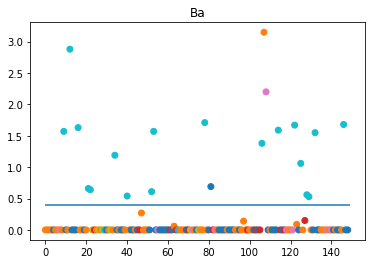

In [7]:
plt.scatter([i for i in range(149)], df[leaf["best_att"]], c=y, cmap=col)
plt.hlines(leaf["best_threshold"], 0, 149)
plt.title(f"{leaf['best_att']}");
#plt.savefig('../Vis/split 1');

In [8]:
clf = DecisionTreeClassifier(max_depth=5)
model = clf.fit(X, y)

In [9]:
sum(model.predict(X)==y)/1.49 #check accuracy of the decision tree at this level

79.86577181208054

[(0, 'RI'), (1, 'Na'), (2, 'Mg'), (3, 'Al'), (4, 'Si'), (5, 'K'), (6, 'Ca'), (7, 'Ba'), (8, 'Fe')]


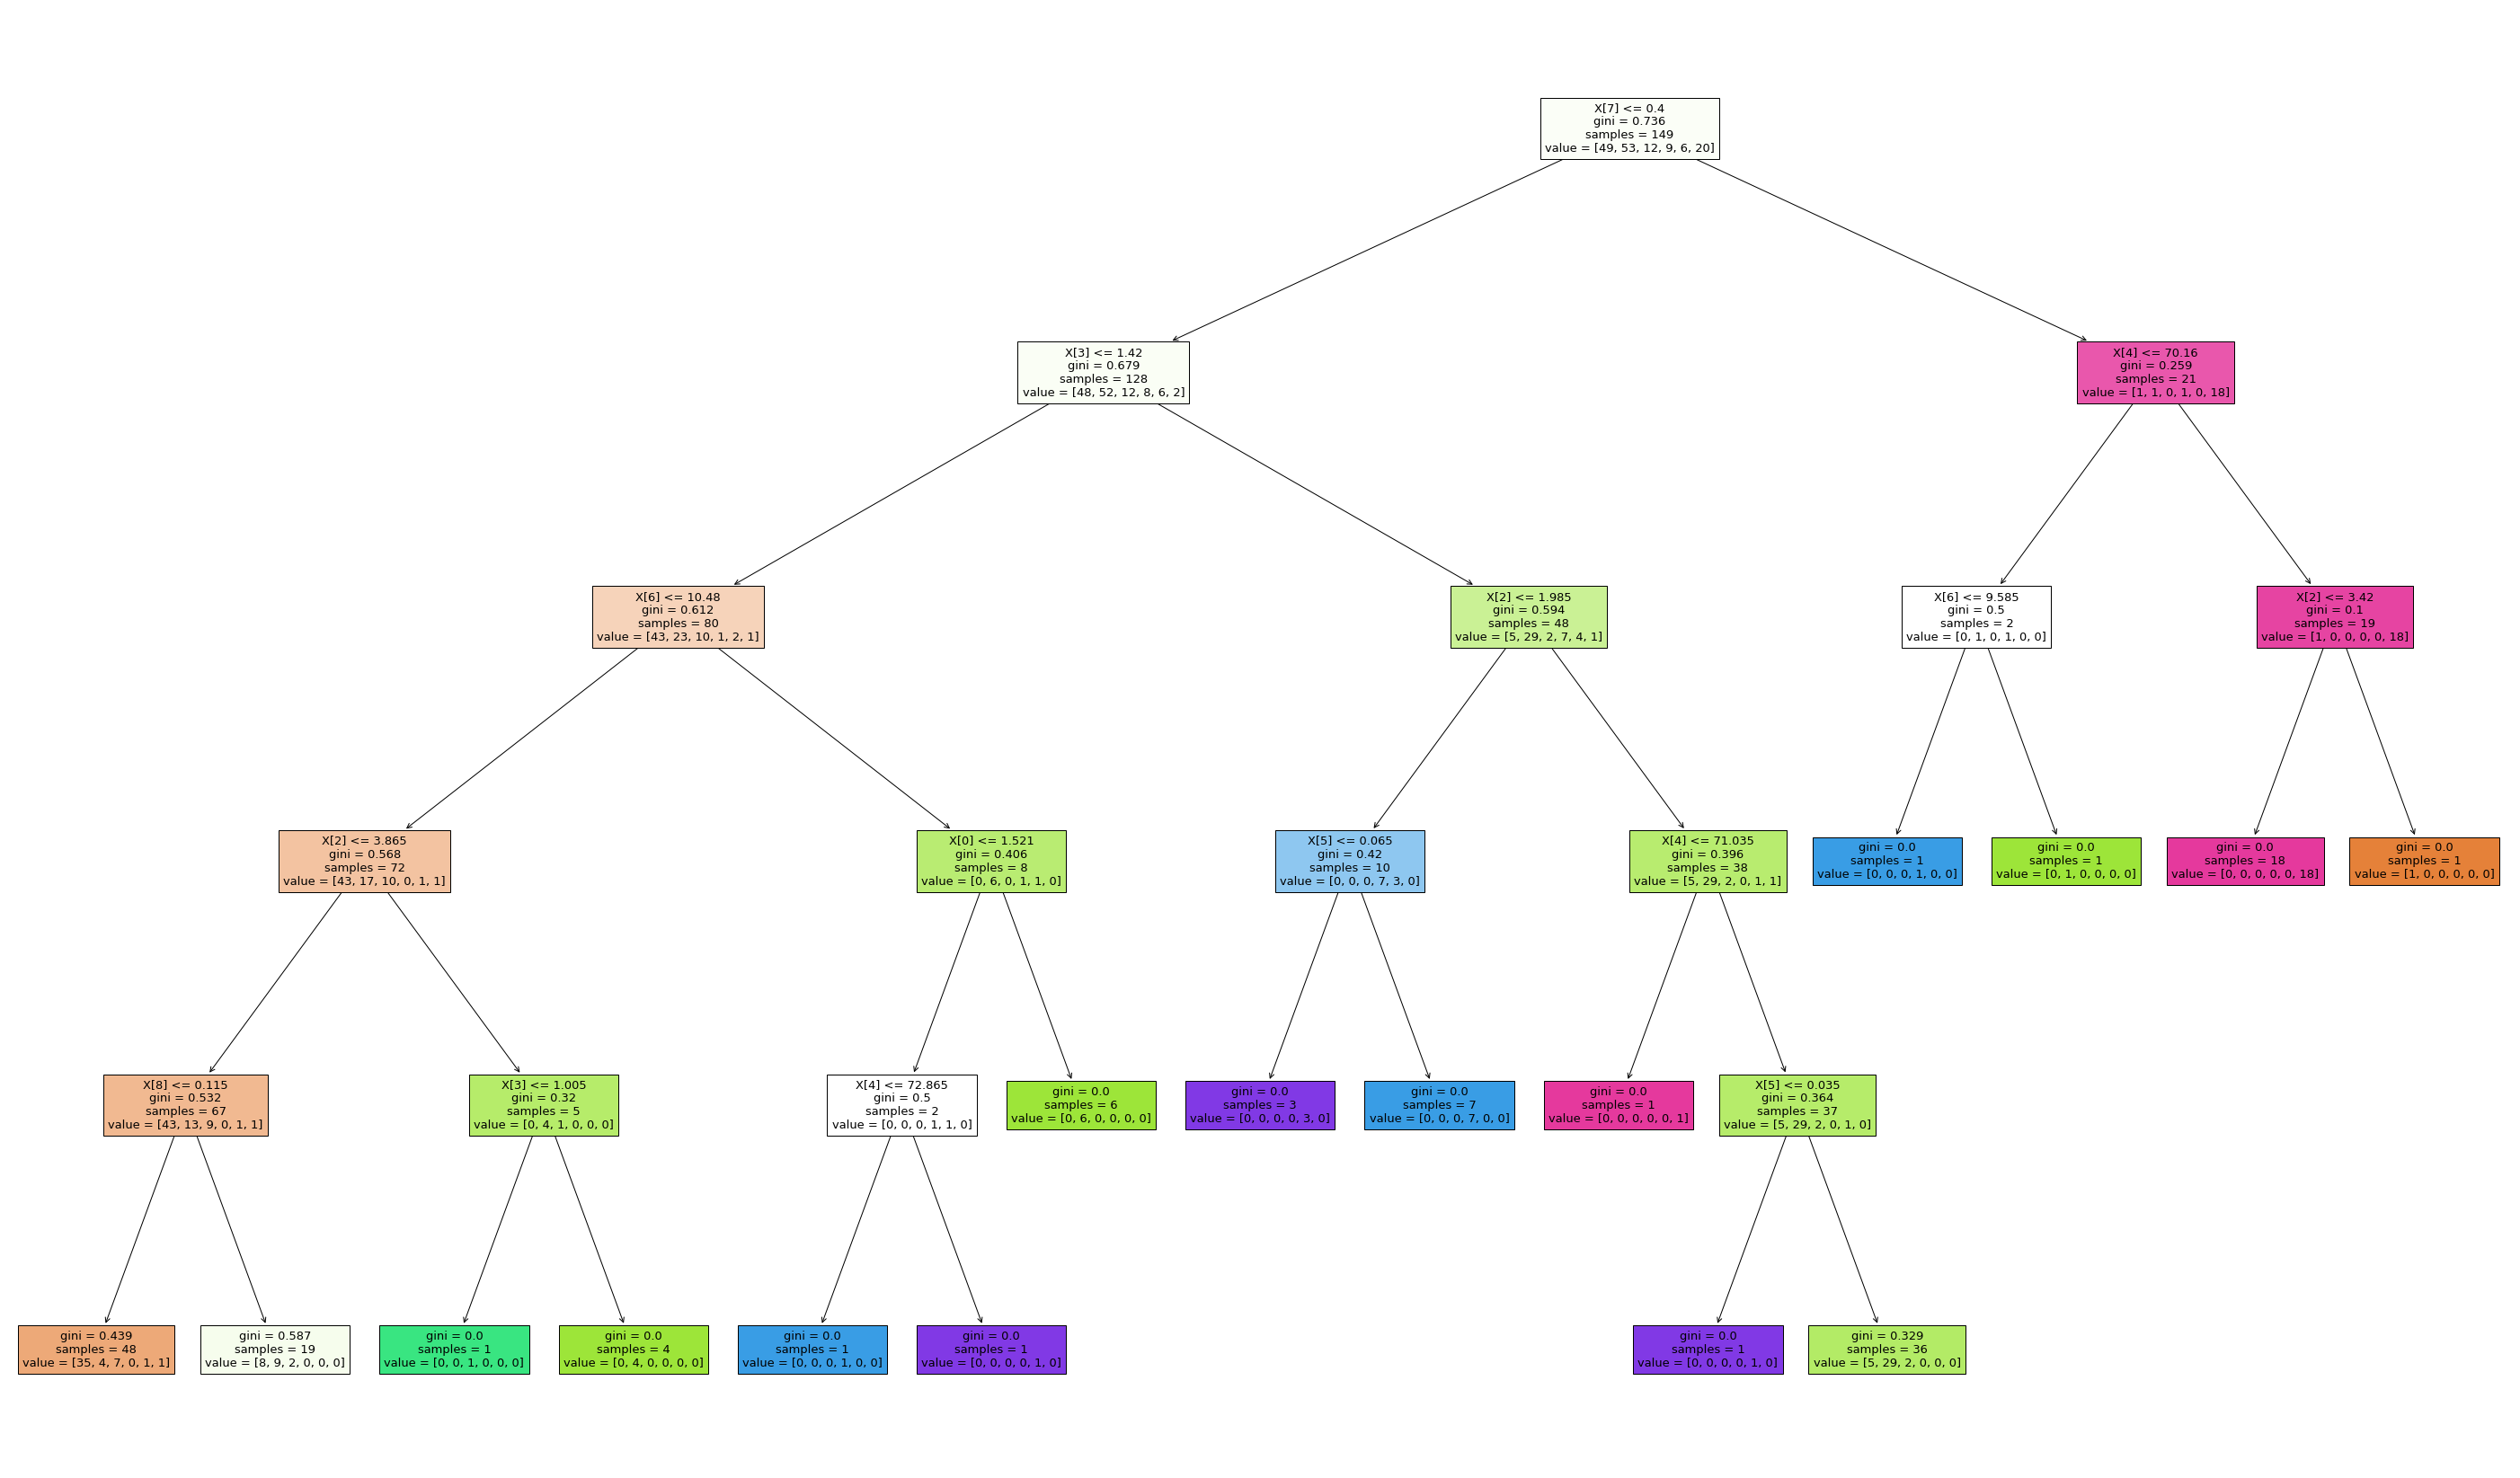

In [10]:
fig = plt.figure(figsize=(50,30))
_ = tree.plot_tree(model, filled= True)
print([(i, attributes[i]) for i in range(len(attributes))]);
#plt.savefig('../Vis/sklearn_tree');

In [11]:
#plt.scatter([i for i in range(149)], df['Ba'], c=y, cmap=col)
#plt.hlines(0.4, 0, 149)
#plt.title('Ba');

128 21
{'best_gini': 0.605, 'best_threshold': 1.42, 'best_att': 'Al', 'node_gini': 0.679, 'class_count': array([ 0, 48, 52, 12,  0,  8,  6,  2])}


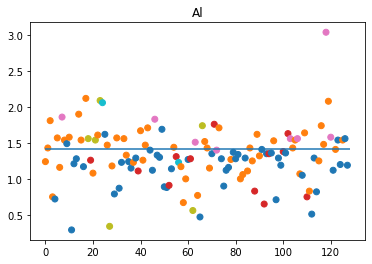

In [12]:
a_df = df[df[leaf['best_att']] <= leaf["best_threshold"]].copy()
b_df = df[df[leaf['best_att']] > leaf["best_threshold"]].copy()
print(a_df.shape[0], b_df.shape[0])

leaf_a  = leaf_hunter(a_df)

print(leaf_a)

plt.scatter([i for i in range(a_df.shape[0])], a_df[leaf_a['best_att']], c=a_df['type'], cmap=col)
plt.hlines(leaf_a["best_threshold"], 0, a_df.shape[0])
plt.title(f'{leaf_a["best_att"]}');
#plt.savefig('../Vis/a_split');

{'best_gini': 0.138, 'best_threshold': 70.16, 'best_att': 'Si', 'node_gini': 0.259, 'class_count': array([ 0,  1,  1,  0,  0,  1,  0, 18])}


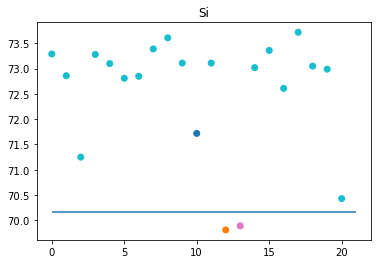

In [13]:
leaf_b  = leaf_hunter(b_df)

print(leaf_b)

plt.scatter([i for i in range(b_df.shape[0])], b_df[leaf_b['best_att']], c=b_df['type'], cmap=col)
plt.hlines(leaf_b["best_threshold"], 0, b_df.shape[0])
plt.title(f'{leaf_b["best_att"]}');
#plt.savefig('../Vis/b_split');

In [14]:
class Noodle:
    
    def __init__(self, df, max_depth=20, print_nodes=False, depth=0):     
        tmp = leaf_hunter(df)
        self.depth = depth
        self.node_gini = tmp['node_gini']
        self.best_gini = tmp['best_gini']
        self.best_att = tmp['best_att']
        self.best_threshold = tmp['best_threshold']
        self.class_count = tmp['class_count']
        self.no_classes = len(np.nonzero(self.class_count)[0])
        self.max_depth = max_depth
        self.classification = int(np.where(self.class_count == np.amax(self.class_count))[0][0]) 
        
        if self.no_classes == 1 or self.max_depth < 1:
            self.has_children = False
        else:
            self.has_children = True
        
        if print_nodes:
            print(self)
            
        if self.depth==0:
            with open('../Report/tree.txt', 'w') as f:
                f.write(f'{str(self)}')
        else:
            with open('../Report/tree.txt', 'a') as f:
                f.write(f'{str(self)}')
                
        
        
        if self.has_children:
            a = df[df[self.best_att] <= self.best_threshold]
            b = df[df[self.best_att] > self.best_threshold]
            self.child_a = Noodle(a, self.max_depth-1, print_nodes, self.depth+1)
            self.child_b = Noodle(b, self.max_depth-1, print_nodes, self.depth+1)
            
            
    def __str__ (self):
        
        peanut = {attributes[i]: i for i in range(len(attributes))}
        peanut[0] = ''
        
        
        return(f'Depth: {self.depth}'
              + f'\n{"  "*self.depth}Node Gini: {self.node_gini}'
              + f'\n{"  "*self.depth}Attribute: {self.best_att} ({peanut[self.best_att]})'
              + f'\n{"  "*self.depth}Threshold: {self.best_threshold}'
              + f'\n{"  "*self.depth}Classes: {self.class_count}'
              + f'\n{"  "*self.depth}No classes: {self.no_classes}'
              + f'\n{"  "*self.depth}Node classification: {self.classification}'
              + f'\n{"  "*self.depth}Has children: {self.has_children}'
              + f'\n{"  "*self.depth}-----------------------\n')
        
    def predict(self, test, force_depth=100):
        classes = []
        for i in range(len(test)):
            t = test.iloc[i]
            searching = True
            sam = bob # makes sam a copy of the decision tree
            while searching:
                if sam.has_children and sam.depth < force_depth: 
                    if t[sam.best_att] <= sam.best_threshold:
                        sam = sam.child_a
                    else:
                        sam = sam.child_b
                else:
                    searching = False
                
            classes.append(sam.classification)
        return classes
        
bob = Noodle(df)#, print_nodes=True) # This fits the model to the data equiv to .fit()

In [15]:
ran = 130
test = X.iloc[[i for i in range(ran, ran+5)]]
pred = bob.predict(test)

[i for i in zip(pred, list(df['type'].iloc[[i for i in range(ran, ran+5)]]))]

[(2, 2), (1, 1), (7, 7), (1, 1), (1, 1)]

In [16]:
banana = 0 # keeps track of correct classifications
df_trained = df.copy()
df_trained['classification'] = ''

for i in range(len(df)):
    test = df.iloc[i]
    searching = True
    sam = bob # makes sam a copy of the decision tree
    while searching:
        if sam.has_children and sam.depth < 11: #change depth here for overtraining stuff
            if test[sam.best_att] <= sam.best_threshold:
                sam = sam.child_a
            else:
                sam = sam.child_b
        else:
            searching = False
    df_trained['classification'].iloc[i] = sam.classification
    if sam.classification == test['type']:
        banana +=1
    else:
        pass
        #print('wrong', i, test['type_desc'], sam.classification)
        
print(f'{round(banana/1.49, 2)}% correct') #should be 100% whilst we are overtraining the model

100.0% correct


In [17]:
df_trained[df_trained['type'] != df_trained['classification']]

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,type,type_desc,classification


In [18]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
for train, test in kf.split(X):
    print(f"\n\n{len(train)}, {len(test)}")
    #bob = Noodle(pd.DataFrame(df.iloc[train]))
    #pred = bob.predict(pd.DataFrame(df.iloc[test]))
    #print([i for i in zip(df.iloc[train], pred)])



119, 30


119, 30


119, 30


119, 30


120, 29


In [19]:
X.iloc[30]

RI     1.516
Na    12.790
Mg     3.610
Al     1.620
Si    72.970
K      0.640
Ca     8.070
Ba     0.000
Fe     0.260
Name: 30, dtype: float64

In [20]:
#loads and predicts on the TEST data, run this last once everything else is in place then don't change stuffs
#df_test = pd.read_csv(TEST) #training dataframe

#X_test = df_test[attributes].round(3).copy() #attributes
#df_test[attributes] = df_test[attributes].round(3)
#y_test = df_test['type'].copy() #true values

#sum([i==j for i,j in zip(bob.predict(X_test), y_test)]), len(X)